<a href="https://colab.research.google.com/github/rczhen/code_ml/blob/main/gpt_dev_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Play with Karpathy's lecture

https://www.youtube.com/watch?v=kCc8FmEb1nY&t=5425s&ab_channel=AndrejKarpathy

https://github.com/karpathy/ng-video-lecture/

https://github.com/karpathy/nanoGPT

In [72]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F

## Data loading, Tokenizer

In [73]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-04-08 08:04:15--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2024-04-08 08:04:15 (14.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [74]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [75]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [76]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [77]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [78]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Practical tokenizers:

https://github.com/google/sentencepiece BERT

https://github.com/openai/tiktoken Open AI models

In [79]:
!pip install tiktoken
import tiktoken

encoder = tiktoken.get_encoding('gpt2')
print(encoder.n_vocab)
print(encoder.encode('hii there'))
print(encoder.decode([71, 4178, 612]))

50257
[71, 4178, 612]
hii there


In [80]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:200]) # the 200 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59])


In [81]:
# Let's now split up the data into train and validation sets
n = int(0.9 * len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [82]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [83]:
# predict next时，最多看 block_size 个input。during training, let the model see input size from 1 to block_size
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [84]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data

    # get a [batch_size, block_size data]
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

## Model v1, simple baseline embedding dim == num of classes

In [85]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    # a model predicting next token only based on itself

    def __init__(self, vocab_size):
        super().__init__()

        # each token directly reads off the logits for the next token from a lookup table
        # 这样设计embedding，是专门为这个，只看自己，预测下一个的baseline model准备的。
        # vocab_size = 65，embedding_dim = 65，对每个token，embedding的含义可理解为，当前token的下一个token为所有token的probability
        # 所以loss才能直接用cross_entropy(embedding, target)算

        # Input: Shape (C), (N,C)
        # Target: If containing class indices, shape (), (N)
        # where C = number of classes, N = batch size

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # (num_embeddings, embedding_dim)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # B*T: for each sample in batch, make it T samples, with input context of length 1, T.
        # as a baseline, only look at itself, i.e. predict 1 to T-1 based on 0 to T
        # B: batch, batch_size = 4
        # T: time, context length = 8
        # C: channel, embedding_dim
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            logits, loss = self(idx) # logits: (B*T, C)

            # focus only on the last time step, predict the next with only one token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb)

print(xb.shape)
print(yb.shape)

print(logits.shape)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


torch.Size([4, 8])
torch.Size([4, 8])
torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [86]:
# compare the loss, 4.8786 with random guess
-np.log(1/65) # -1 * log likelihood of a uniform probability

4.174387269895637

In [87]:
# create a PyTorch optimizer
# typically start the learning rate with 3e-4, however for such a small model can use larger
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.5727508068084717


In [88]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y helti


## Matrix tricks: lower triangular matrix

In [89]:
# to simply average on all preceding tokens

In [90]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)

a = torch.tril(torch.ones(3, 3))  # lower triangular matrix
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3,2)).float()
c = a @ b  # same as c = torch.matmul(a, b)

print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)
# c[0] is b[0]
# c[1] is the average of b[0], b[1]
# c[2] is the average of b[0], b[1], b[2]

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [91]:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)

In [92]:
# version 1: brute force

# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))

for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t+1, C), embeddings for all preceding tokens
        xbow[b,t] = torch.mean(xprev, 0) # collapsing on axies=0, i.e. average all preceding tokens


In [93]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [94]:
xbow[0]
# xbow[0] is x[0]
# xbow[1] is the average of x[0], x[1], and so on

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [95]:
# version 2: using matrix multiply for a weighted aggregation
weights = torch.tril(torch.ones(T, T))
weights = weights / weights.sum(1, keepdim=True)
print(weights)

xbow2 = weights @ x # (B, T, T) @ (B, T, C) ----> (B, T, C). weights is originally (T, T), broadcasting duplicates B times as (B, T, T)
torch.allclose(xbow, xbow2) # xbow and xbow2 should be identical

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


False

In [96]:
print(xbow[1])
print(xbow2[1])

tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])
tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])


In [97]:
# version 3: use Softmax
# 和读paper联动了
# 这是simple average all embedding的做法。self attention中，weights对不同的token embedding有同的权重
# 相比version 2，其实就是给权重加了个softmax，在weights不一样时会体现出区别

weights = torch.zeros((T,T))
print(weights)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
print(weights)

weights = F.softmax(weights, dim=-1)
print(weights)

xbow3 = weights @ x
torch.allclose(xbow, xbow3)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000,

False

## Model v2: with linear layer after token embedding

In [98]:
# model v2
# 1. add embedding_dim, and a linear output layer so that embedding_dim no longer need to be vocab_size

class BigramLanguageModel(nn.Module):
    # a model predicting next token only based on itself

    def __init__(self, vocab_size=65, embedding_dim=32):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim) # (num_embeddings, embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,embedding_dim)
        logits = self.lm_head(token_emb) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            logits, loss = self(idx) # logits: (B*T, C)

            # focus only on the last time step, predict the next with only one token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

model = BigramLanguageModel()
logits, loss = model(xb, yb)

print(xb.shape)
print(yb.shape)

print(logits.shape)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([256, 65])
tensor(4.3442, grad_fn=<NllLossBackward0>)

ERS'paokq3zs$DA$zF-QTkeMk;x-AQaFCLg!iW3.O!tDGxA MsT3!dK-!KpcVeJydKJSrsA&Rqt!:!wWSz.WxbjBiDeLhsKya;fK


In [99]:
# typically start the learning rate with 3e-4, however for such a small model can use larger
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.453615427017212


加了linear layer后，2.453615427017212 的loss，相比之前的 2.5727508068084717，要好

## Single Head Self-Attention, Scaled Dot-Product Attention, and model v3

In [101]:
# version 4: self attention: data dependent way to decide token to token attention

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch size, time/context length, channels/embedding_dim
x = torch.randn(B,T,C)

# single head self attention
# key: what do I contain
# query: what do I looking for
# value: private content of a token

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
weights = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) --> (B, T, T), transpose the last 2 dimensions, keep calculation within a sample

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
print(weights[0])

# weights has a shape of (B, T, T), (a sample in a batch, a token in all tokens, attention to all other tokens), softmax along the last dim
weights = F.softmax(weights, dim=-1)
print(weights[0]) # softmax normalization shows up

v = value(x)
out = weights @ v # (B, T, T) @ (B, T, head_size) --> (B, T, head_size)

print(out.shape)

# notes
# 1. as we can see no positional (absolute or relative) information is encoded. CNN has relative local info by convolute with only neighbors
#    hence positional encoding is needed.
# 2. batch matrix mul. different samples within a batch do not talk with each other
# 3. this is a decoder setting (auto-regressive), which a token is only allowed to see preceding tokens
#    for encoder setting, or simply want to see all tokens, just remove: weights = weights.masked_fill(tril == 0, float('-inf'))
# 4. self attention mean, KQV are all emit from itself, i.e. k = key(x), q = query(x), v = value(x)
#    there could be "cross attention". say in Transformer's encoder-decoder setting, query comes from x, while key and value come from encoder.


tensor([[-1.7629,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-3.3334, -1.6556,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-1.0226, -1.2606,  0.0762,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.7836, -0.8014, -0.3368, -0.8496,    -inf,    -inf,    -inf,    -inf],
        [-1.2566,  0.0187, -0.7880, -1.3204,  2.0363,    -inf,    -inf,    -inf],
        [-0.3126,  2.4152, -0.1106, -0.9931,  3.3449, -2.5229,    -inf,    -inf],
        [ 1.0876,  1.9652, -0.2621, -0.3158,  0.6091,  1.2616, -0.5484,    -inf],
        [-1.8044, -0.4126, -0.8306,  0.5899, -0.7987, -0.5856,  0.6433,  0.6303]],
       grad_fn=<SelectBackward0>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.02

In [102]:
# scaled dot product attention
k = torch.randn(B, T, head_size)  # unit Guassian inputs
q = torch.randn(B, T, head_size)
weights = q @ k.transpose(-2, -1)

print(k.var())
print(q.var())
print(weights.var())

weights = q @ k.transpose(-2, -1) * head_size ** -0.5
print(weights.var())

# if no normalization, the variance of weights wil be on the order of head_size, here is 16
# when deviding by sqrt(head_size), bring the variance back
# "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too
# and Softmax will stay diffuse and not saturate too much.

tensor(1.0449)
tensor(1.0700)
tensor(17.4690)
tensor(1.0918)


In [103]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [104]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot/sharpen towards the max

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [105]:
class SingleHeadSelfAttention(nn.Module):
    """one head of self attention"""

    def __init__(self, d_model, head_size=16, block_size=8):
        """
        d_model: embedding dim, previous C
        head_size: size of KQV embeddings
        block_size: max context length, previous T
        """
        super().__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.block_size = block_size

        self.w_key = nn.Linear(d_model, head_size, bias=False)
        self.w_query = nn.Linear(d_model, head_size, bias=False)
        self.w_value = nn.Linear(d_model, head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.w_key(x) # (B,T,head_size)
        q = self.w_query(x) # (B,T,head_size)

        # compute attention scores
        attentions = q @ k.transpose(-2, -1) * (self.head_size ** -0.5) # (B,T,head_size) @ (B,head_size,T) --> (B, T, T)
        attentions = attentions.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        attentions = F.softmax(attentions, dim=-1) # (B, T, T)

        # weighted sum of values
        v = self.w_value(x)
        out = attentions @ v  # (B, T, T) @ (B,T,head_size) --> (B,T,head_size)

        return out


In [106]:
# v3 model, add positional encoding and single head self attention
# 1. add position embedding. pass token_emb + pos_emb to output layer
# 2. add SingleHeadSelfAttention
# 3. crop input sequence length, so that it does not exceed the size of position_embedding_table

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65, embedding_dim=32, block_size=8):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim) # (num_embeddings, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.attention_layer = SingleHeadSelfAttention(d_model=embedding_dim)
        self.lm_head = nn.Linear(16, vocab_size) # head size is 16

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,embedding_dim)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, embedding_dim)
        x = token_emb + pos_emb # (B,T,embedding_dim), broadcasting

        x = self.attention_layer(x)# (B,T,embedding_dim) --> # (B,T,head_size), multi-head will remain embedding_dim

        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx/input sequence length
            idx_corp = idx[:, -block_size:]

            logits, loss = self(idx_corp) # logits: (B*T, C)

            # focus only on the last time step, predict the next with only one token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

model = BigramLanguageModel()
logits, loss = model(xb, yb)

print(xb.shape)
print(yb.shape)

print(logits.shape)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([256, 65])
tensor(4.2837, grad_fn=<NllLossBackward0>)

AzRuYYiLEKBPX!UKX'qBjQ3!!e.bAF:WmRKrkTlkJmdFMJqmbhDr!YCD Gzsys:zKRj .ysTt tTgO'bov$po$raxDmx;e$3sCXq


In [107]:
# typically start the learning rate with 3e-4, however for such a small model can use larger
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.3911821842193604


In [108]:
# the loss, 2.29, is much lower than the previous 2.4x and 2.5x. see how the generation looks like
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


Peened den sinsth hishen tear:
He bt thisin argo gs fran bee nanis theer so,
K:
Frot wiet re, higay 


## Multi-Head Self Attention and model v4

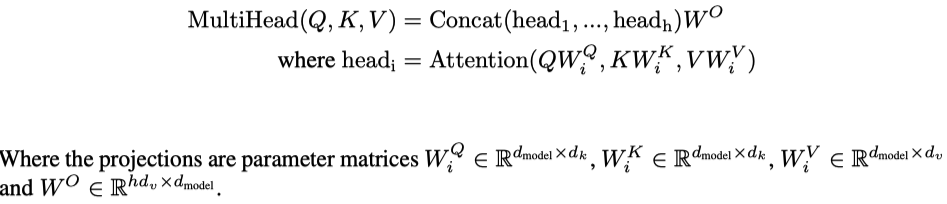

In [109]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        d_model = num_heads * head_size
        self.heads = nn.ModuleList(SingleHeadSelfAttention(d_model, head_size) for _ in range(num_heads))
        self.w_output = nn.Linear(d_model, d_model)

    def forward(self, x):
        head_outs = [head(x) for head in self.heads] # shape of single head output: (B,T,head_size)
        x = torch.cat(head_outs, dim=-1)
        x = self.w_output(x)
        return x


In [110]:
# v4 model, with multi-head self attention

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65, embedding_dim=32, block_size=8):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim) # (num_embeddings, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.attention_layer = MultiHeadAttention(num_heads=4, head_size=8) # num_heads * head_size = embedding_dim
        self.lm_head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,embedding_dim)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, embedding_dim)
        x = token_emb + pos_emb # (B,T,embedding_dim), broadcasting

        x = self.attention_layer(x)# (B,T,embedding_dim) --> # (B,T,embedding_dim)

        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx/input sequence length
            idx_corp = idx[:, -block_size:]

            logits, loss = self(idx_corp) # logits: (B*T, C)

            # focus only on the last time step, predict the next with only one token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

model = BigramLanguageModel()
logits, loss = model(xb, yb)

print(xb.shape)
print(yb.shape)

print(logits.shape)
print(loss)

idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([256, 65])
tensor(4.1555, grad_fn=<NllLossBackward0>)

L3Z$DEKFWndVd
SnLjaHszsrxGJ$pf?Nhf
gkcBhoH?nC-UXWiTBb,l&e$3$&
SrAAWRzJBvGK-wNJXNGUbXE;z kE'wXhnphO. 


In [111]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.109943151473999


In [112]:
# the loss 2.10, a large improvement compared with the 2.29 of single head
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))


The bestthend kin thea athe orsdfies rer, with as Roold to Pues?
 that Exor evauldie of pallubled'd 


## Feed Forward Network (simply MLP with ReLU) and model v4.5

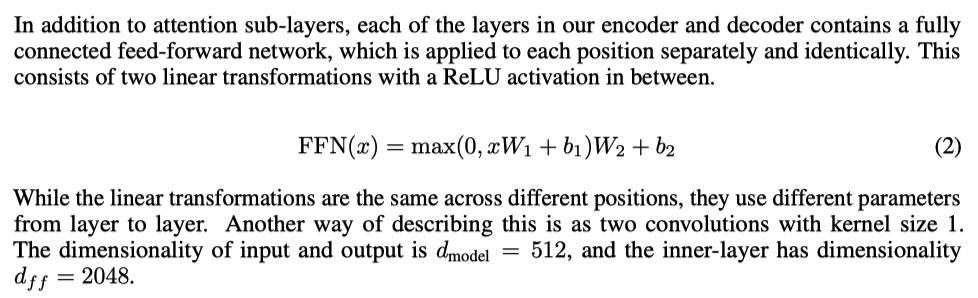

In [113]:
class FeedForwardLayer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
        )

    def forward(self, x):
        return self.net(x)


In [114]:
# v4.5 model, with multi-head self attention + feed forward net

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65, embedding_dim=32, block_size=8):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim) # (num_embeddings, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.attention_layer = MultiHeadAttention(num_heads=4, head_size=8) # num_heads * head_size = embedding_dim
        self.ffn = FeedForwardLayer(d_model=embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,embedding_dim)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, embedding_dim)
        x = token_emb + pos_emb # (B,T,embedding_dim), broadcasting

        x = self.attention_layer(x)# (B,T,embedding_dim) --> # (B,T,embedding_dim)

        x = self.ffn(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx/input sequence length
            idx_corp = idx[:, -block_size:]

            logits, loss = self(idx_corp) # logits: (B*T, C)

            # focus only on the last time step, predict the next with only one token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

model = BigramLanguageModel()

In [115]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

1.9448461532592773


In [116]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))



Whums, my thee andly nothereted.

Thy godly this, ans, thoren
them con, prouths welpinfjence,
By fo


## Layer Norm and Batch Norm

2 optimizations to make the deep model trains well: 1. residual connection, 2. layer norm

addition distributes gradient equally into 2 branches

In [117]:
class LayerNorm1d: # (used to be BatchNorm1d)

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # sample mean
        xvar = x.var(1, keepdim=True) # sample variance

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance

        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


In [118]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [119]:
torch.manual_seed(1337)
ln = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = ln(x)
print(x.shape)

# mean,std of one feature across all batch inputs
print(x[:,0].mean(), x[:,0].std())

# mean,std of a single input from the batch, of its features
print(x[0,:].mean(), x[0,:].std())

torch.Size([32, 100])
tensor(0.1469) tensor(0.8803)
tensor(-9.5367e-09) tensor(1.0000)


In [120]:
torch.manual_seed(1337)
bn = BatchNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = bn(x)
print(x.shape)

# mean,std of one feature across all batch inputs
print(x[:,0].mean(), x[:,0].std())

# mean,std of a single input from the batch, of its features
print(x[0,:].mean(), x[0,:].std())

torch.Size([32, 100])
tensor(7.4506e-09) tensor(1.0000)
tensor(0.0411) tensor(1.0431)


## Transformer Block, Residual Connection

In [123]:
class Block(nn.Module):
    """Transformer block"""

    def __init__(self, d_model, num_heads):
        super().__init__()

        head_size = d_model // num_heads
        self.attention_layer = MultiHeadAttention(num_heads, head_size)
        self.ffn = FeedForwardLayer(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # residual connections are added between all layers in the block

        # one thing has changed from the original paper in the past several years (very limited though)
        # in the original paper, Add & Norm stays together, LayerNorm(x + Sublayer(x))
        # now layer norm are performed before passing into sublayer: x + Sublayer(LayerNorm(x))

        x = self.ln1(x)
        x = x + self.attention_layer(x)
        x = self.ln2(x)
        x = x + self.ffn(x)
        return x


In [126]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size=65, embedding_dim=32, block_size=8):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim) # (num_embeddings, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)

        # self.attention_layer = MultiHeadAttention(num_heads=4, head_size=8) # num_heads * head_size = embedding_dim
        # self.ffn = FeedForwardLayer(d_model=embedding_dim)
        self.blocks = nn.Sequential(
            Block(embedding_dim, num_heads=4),
            Block(embedding_dim, num_heads=4),
            Block(embedding_dim, num_heads=4),
        )

        self.ln_f = nn.LayerNorm(embedding_dim) # final layer norm before head
        self.lm_head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,embedding_dim)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, embedding_dim)
        x = token_emb + pos_emb # (B,T,embedding_dim), broadcasting

        x = self.blocks(x) # (B,T,embedding_dim) --> # (B,T,embedding_dim)

        x = self.ln_f(x) # (B,T,embedding_dim)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context

        for _ in range(max_new_tokens):
            # crop idx/input sequence length
            idx_corp = idx[:, -block_size:]

            logits, loss = self(idx_corp) # logits: (B*T, C)

            # focus only on the last time step, predict the next with only one token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx

model = BigramLanguageModel()

In [127]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 32
for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.0192248821258545


In [129]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist()))



NORCHHAP breed.
For armfuilthings your had pa-rar is a
as Que, le's beains lenvance choppar their w


## Final Full Model, Scale Up, Add Dropout

Dropout can be added right before the residual connection. Here dropouts are added:
1. end of feed forward networl
2. after calculating the self-attention scores, before multiple with value to get the weighted sum, to prevent some nodes to communicate
3. after the linear transformation of the concatenation of self-attention layer outputs


In [130]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5059
step 300: train loss 2.4196, val loss 2.4338
step 400: train loss 2.3504, val loss 2.3566
step 500: train loss 2.2965, val loss 2.3129
step 600: train loss 2.2410, val loss 2.2500
step 700: train loss 2.2057, val loss 2.2191
step 800: train loss 2.1633, val loss 2.1864
step 900: train loss 2.1244, val loss 2.1510
step 1000: train loss 2.1038, val loss 2.1308
step 1100: train loss 2.0707, val loss 2.1197
step 1200: train loss 2.0377, val loss 2.0800
step 1300: train loss 2.0268, val loss 2.0650
step 1400: train loss 1.9918, val loss 2.0356
step 1500: train loss 1.9697, val loss 2.0293
step 1600: train loss 1.9645, val loss 2.0499
step 1700: train loss 1.9404, val loss 2.0129
step 1800: train loss 1.9095, val loss 1.9951
step 1900: train loss 1.9067, val loss 1.9855
step 2000: train loss 1.8854, val loss 1.9948
step 2100: train loss 1.